# 🧠 Deep Generative Models - VAE

### Artin Tavasoli

### 📘 **Student ID:** 810102543

# 1. Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mutual_info_score
from tqdm import tqdm
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dropout, LeakyReLU, BatchNormalization
import gc

2025-11-06 14:13:05.109468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762438385.569534      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762438385.704607      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Hyperparameters

In [ ]:
input_shape = (64, 64, 1)
filters     = [32, 64, 128]
dense_h     = 256
latent_dim  = 16
num_downsample = 3
batch_size  = 256
epochs      = 50
beta        = 1.0
val_split   = 0.05
learning_rate = 1e-3
optimizer_mode = Adam
max_samples = 200_000

# 3. Dataset

[dsprites](https://github.com/google-deepmind/dsprites-dataset) dataset

In [ ]:
!wget -O dsprites.npz \
  https://github.com/google-deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz


--2025-11-06 14:13:23--  https://github.com/google-deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-deepmind/dsprites-dataset/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz [following]
--2025-11-06 14:13:23--  https://raw.githubusercontent.com/google-deepmind/dsprites-dataset/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19318135 (18M) [application/octet-stream]
Saving to: ‘dsprites.npz’

dsprites.npz        100%[===================>]  18.42M   

In [ ]:
data = np.load('dsprites.npz', mmap_mode='r', allow_pickle=True, encoding='latin1')

images = data['imgs']
latents_values = data['latents_values']
latents_classes = data['latents_classes']
metadata = data['metadata'].item()

  idx= 462886
  class=1, value=2.00)
  scale: class=5, value=1.000
  orientation: class=12, value=1.933 rad
  posX: class=1, value=0.032
  posY: class=6, value=0.194
  metadata.latents_names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
  metadata.latents_sizes: [ 1  3  6 40 32 32]
---------------------------------------------------------


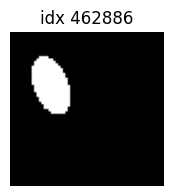

  idx= 382727
  class=1, value=2.00)
  scale: class=3, value=0.800
  orientation: class=13, value=2.094 rad
  posX: class=24, value=0.774
  posY: class=7, value=0.226
  metadata.latents_names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
  metadata.latents_sizes: [ 1  3  6 40 32 32]
---------------------------------------------------------


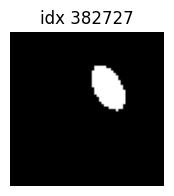

  idx= 66358
  class=0, value=1.00)
  scale: class=1, value=0.600
  orientation: class=24, value=3.867 rad
  posX: class=25, value=0.806
  posY: class=22, value=0.710
  metadata.latents_names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
  metadata.latents_sizes: [ 1  3  6 40 32 32]
---------------------------------------------------------


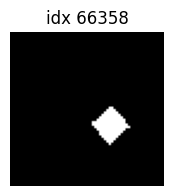

  idx= 469511
  class=1, value=2.00)
  scale: class=5, value=1.000
  orientation: class=18, value=2.900 rad
  posX: class=16, value=0.516
  posY: class=7, value=0.226
  metadata.latents_names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
  metadata.latents_sizes: [ 1  3  6 40 32 32]
---------------------------------------------------------


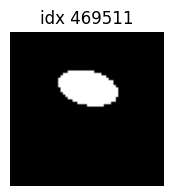

  idx= 624996
  class=2, value=3.00)
  scale: class=3, value=0.800
  orientation: class=10, value=1.611 rad
  posX: class=11, value=0.355
  posY: class=4, value=0.129
  metadata.latents_names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
  metadata.latents_sizes: [ 1  3  6 40 32 32]
---------------------------------------------------------


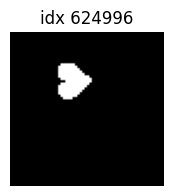

In [ ]:
NUMBER_OF_IMAGES = 5
class DSprite:
    def __init__(self, index, image, latents_values, latents_classes, metadata):
        self.index = index
        self.image = image
        self.values = latents_values
        self.classes = latents_classes
        self.metadata = metadata

    def print_info(self):
        print(f"  idx= {self.index}")
        print(f"  class={int(self.classes[1])}, value={self.values[1]:.2f})")
        print(f"  scale: class={int(self.classes[2])}, value={self.values[2]:.3f}")
        print(f"  orientation: class={int(self.classes[3])}, value={self.values[3]:.3f} rad")
        print(f"  posX: class={int(self.classes[4])}, value={self.values[4]:.3f}")
        print(f"  posY: class={int(self.classes[5])}, value={self.values[5]:.3f}")
        print(f"  metadata.latents_names: {self.metadata.get('latents_names')}")
        print(f"  metadata.latents_sizes: {self.metadata.get('latents_sizes')}")
        print("---------------------------------------------------------")

    def show(self):
        plt.figure(figsize=(2,2))
        plt.imshow(self.image, cmap='gray')
        plt.title(f"idx {self.index}")
        plt.axis("off")
        plt.show()

rng = np.random.default_rng()
indices = rng.choice(images.shape[0], size=NUMBER_OF_IMAGES, replace=False)
sprites = list()
for i in indices:
    index = int(i)
    sprites.append(DSprite(index, images[index], latents_values[index], latents_classes[index], metadata))


for sprite in sprites:
    sprite.print_info()
    sprite.show()


In [ ]:
images.shape

(737280, 64, 64)

add a color channel

In [ ]:
x = np.expand_dims(images, -1)

# 4. Train/Val Dataset

In [ ]:
rng = np.random.default_rng()
subset_indices = rng.choice(x.shape[0], size=min(max_samples, x.shape[0]), replace=False)
x_subset = x[subset_indices]

N = x_subset.shape[0]
n_val = int(val_split * N)
perm = np.random.permutation(N)
x_val = x_subset[perm[:n_val]]
x_train = x_subset[perm[n_val:]]

train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(buffer_size=min(4096, x_train.shape[0]))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
    .map(lambda x: tf.cast(x, tf.float32))
)

val_ds = (
    tf.data.Dataset.from_tensor_slices(x_val)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
    .map(lambda x: tf.cast(x, tf.float32))
)
print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}")

I0000 00:00:1762438414.550237      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762438414.550979      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training samples: 190000, Validation samples: 10000


# 5. Encoder


In [ ]:
class Sample(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

def encoder_model(input_shape, filters, dense_h, latent_dim):
    x_in = Input(shape=input_shape, name="encoder_input")

    x = Conv2D(filters[0], kernel_size=3, strides=2, padding="same", name="conv1")(x_in)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(filters[1], kernel_size=3, strides=2, padding="same", name="conv2")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.2)(x)

    x = Conv2D(filters[2], kernel_size=3, strides=2, padding="same", name="conv3")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.2)(x)

    x = Flatten(name="flatten")(x)

    x = Dense(dense_h, name="dense_h")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.2)(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sample(name="z")([z_mean, z_log_var])

    encoder = Model(x_in, [z_mean, z_log_var, z], name="encoder")
    return encoder


encoder = encoder_model(input_shape, filters, dense_h, latent_dim)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 16, 16,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 8, 8, 128) │     73,856 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_h (Dense)     │ (None, 256)       │  2,097,408 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_h[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,200,224 (8.39 MB)

 Trainable params: 2,199,264 (8.39 MB)

 Non-trainable params: 960 (3.75 KB)

# 6. Decoder

### Mirror encoder according to num of downsampling
Process: 8,8,128 -> (Conv2D.T) -> 16,16,128 -> (Conv2D.T) -> 32,32,64 -> (Conv2D.T) -> 64,64,1

in the below cell we'll construct the initial dimensions of decoder input (8,8,128)

In [ ]:
H_init = input_shape[0] // (2**num_downsample)
W_init = input_shape[1] // (2**num_downsample)
C_init = filters[-1]
conv_feat_shape = (H_init, W_init, C_init)

In [ ]:
def decoder_model(latent_dim, conv_feat_shape, filters):
    latent_inputs = Input(shape=(latent_dim,))

    x = Dense(np.prod(conv_feat_shape), activation="relu")(latent_inputs)
    x = Reshape(conv_feat_shape)(x)

    x = Conv2DTranspose(filters[2], 3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters[0], 3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    out = Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
    return Model(latent_inputs, out, name="decoder")

decoder = decoder_model(latent_dim, conv_feat_shape, filters)
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,289 (1.45 MB)

 Trainable params: 379,841 (1.45 MB)

 Non-trainable params: 448 (1.75 KB)

# 7. VAE

In [ ]:
class EpochProgressBar(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs:int):
        super().__init__()
        self.total_epochs = int(total_epochs)
        self._bar = None

    def on_train_begin(self, logs=None):
        self._bar = tqdm(total=self.total_epochs, desc="Epochs", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._bar.update(1)
        self._bar.set_postfix({
            "loss": f"{logs.get('total_loss', 0):.4f}",
            "recon": f"{logs.get('reconstruction_loss', 0):.4f}",
            "kl": f"{logs.get('kl_loss', 0):.4f}",
            "val": f"{logs.get('val_total_loss', float('nan')):.4f}" if "val_total_loss" in logs else "-"
        })

        line = (f"Epoch {epoch+1}/{self.total_epochs} - "
                f"loss: {logs.get('total_loss', 0):.4f} - "
                f"recon_loss: {logs.get('reconstruction_loss', 0):.4f} - "
                f"kl_loss: {logs.get('kl_loss', 0):.4f}")
        if "val_total_loss" in logs:
            line += f" - val_loss: {logs['val_total_loss']:.4f}"
        print(line)

    def on_train_end(self, logs=None):
        if self._bar is not None:
            self._bar.close()

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta    = beta

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

        self.val_total_loss_tracker = Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = Mean(name="val_reconstruction_loss")
        self.val_kl_loss_tracker = Mean(name="val_kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker
        ]

    def call(self, x, training=False):
        z_mean, z_log_var, z = self.encoder(x, training=training)
        reconstruction = self.decoder(z, training=training)
        return z_mean, z_log_var, z, reconstruction

    def encode(self, dataset):
        latent_means = []
        for batch in dataset:
            z_mean, z_log_var, z, reconstruction = self(batch, training=False)
            latent_means.append(z_mean.numpy())
        return np.concatenate(latent_means, axis=0)
    def reconstruct(self, dataset, num_samples=8):
        for batch in dataset.take(1):
            x_batch = batch[:num_samples]
            z_mean, z_log_var, z, reconstruction = self(x_batch, training=False)
            return x_batch.numpy(), reconstruction.numpy()


    def calculate_losses(self, x, x_hat, z_mean, z_log_var):
        reconstruction_loss_per_pixel = tf.keras.losses.binary_crossentropy(x, x_hat)
        reconstruction_loss_per_sample = tf.reduce_sum(
            reconstruction_loss_per_pixel, axis=[-3, -2, -1]
        )
        reconstruction_loss = tf.reduce_mean(reconstruction_loss_per_sample)

        kl_per_sample = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        kl_loss = tf.reduce_mean(kl_per_sample)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, reconstruction = self(x, training=True)
            total_loss, reconstruction_loss, kl_loss = self.calculate_losses(x, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, x):
        z_mean, z_log_var, z, reconstruction = self(x, training=False)
        total_loss, reconstruction_loss, kl_loss = self.calculate_losses(x, reconstruction, z_mean, z_log_var)

        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),
        }
    def reset_metrics(self):
        super().reset_metrics()
        self.val_total_loss_tracker.reset_state()
        self.val_reconstruction_loss_tracker.reset_state()
        self.val_kl_loss_tracker.reset_state()

In [ ]:
def show_reconstructions(model, dataset, beta_value, num_samples=8):
    x_orig, x_recon = model.reconstruct(dataset, num_samples=num_samples)

    plt.figure(figsize=(16, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(x_orig[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=12)

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(x_recon[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Recon", fontsize=12)

    plt.suptitle(f"β = {beta_value} Reconstruction Samples", fontsize=14)
    plt.show()

In [ ]:
def estimate_mutual_information(latent_means, factors, n_bins=20):
    N, latent_dim = latent_means.shape
    n_factors = factors.shape[1]
    latent_discrete = np.zeros_like(latent_means, dtype=np.int32)
    for j in range(latent_dim):
        bins = np.histogram_bin_edges(latent_means[:, j], bins=n_bins)
        latent_discrete[:, j] = np.digitize(latent_means[:, j], bins) - 1

    mi_matrix = np.zeros((n_factors, latent_dim))
    for i in tqdm(range(n_factors), desc="Computing MI matrix"):
        for j in range(latent_dim):
            mi_matrix[i, j] = mutual_info_score(factors[:, i], latent_discrete[:, j])

    return mi_matrix


def compute_MIG(latent_means, factors, n_bins=20):
    mi_matrix = estimate_mutual_information(latent_means, factors, n_bins)

    H_v = np.array([mutual_info_score(f, f) for f in factors.T])
    sorted_mi = np.sort(mi_matrix, axis=1)[:, ::-1]

    mig_per_factor = (sorted_mi[:, 0] - sorted_mi[:, 1]) / (H_v + 1e-12)
    overall_mig = np.mean(mig_per_factor)

    return overall_mig, mig_per_factor

# 8. Train(beta 1)


=== Training beta-VAE (beta=1) ===


Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1762438427.534934      98 service.cc:148] XLA service 0x2d9b8140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762438427.536984      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762438427.537008      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762438428.477969      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762438440.126098      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epochs:   2%|▏         | 1/50 [01:14<1:00:55, 74.61s/epoch, loss=58323.9297, recon=56563.7891, kl=1760.2269, val=13235.8828]

Epoch 1/50 - loss: 58323.9297 - recon_loss: 56563.7891 - kl_loss: 1760.2269 - val_loss: 13235.8828


Epochs:   4%|▍         | 2/50 [01:59<45:43, 57.16s/epoch, loss=14838.8584, recon=14712.2773, kl=126.5906, val=12279.3877]   

Epoch 2/50 - loss: 14838.8584 - recon_loss: 14712.2773 - kl_loss: 126.5906 - val_loss: 12279.3877


Epochs:   6%|▌         | 3/50 [02:46<40:57, 52.29s/epoch, loss=13410.1602, recon=13286.6680, kl=123.4998, val=9345.2207] 

Epoch 3/50 - loss: 13410.1602 - recon_loss: 13286.6680 - kl_loss: 123.4998 - val_loss: 9345.2207


Epochs:   8%|▊         | 4/50 [03:32<38:12, 49.83s/epoch, loss=12493.8975, recon=12371.7725, kl=122.1266, val=8642.2051]

Epoch 4/50 - loss: 12493.8975 - recon_loss: 12371.7725 - kl_loss: 122.1266 - val_loss: 8642.2051


Epochs:  10%|█         | 5/50 [04:18<36:20, 48.45s/epoch, loss=11958.0664, recon=11836.2422, kl=121.8256, val=9160.9434]

Epoch 5/50 - loss: 11958.0664 - recon_loss: 11836.2422 - kl_loss: 121.8256 - val_loss: 9160.9434


Epochs:  12%|█▏        | 6/50 [05:04<34:55, 47.63s/epoch, loss=11545.5684, recon=11424.7754, kl=120.7983, val=8347.6172]

Epoch 6/50 - loss: 11545.5684 - recon_loss: 11424.7754 - kl_loss: 120.7983 - val_loss: 8347.6172


Epochs:  14%|█▍        | 7/50 [05:50<33:45, 47.12s/epoch, loss=11185.2275, recon=11064.7822, kl=120.4339, val=7938.8452]

Epoch 7/50 - loss: 11185.2275 - recon_loss: 11064.7822 - kl_loss: 120.4339 - val_loss: 7938.8452


Epochs:  16%|█▌        | 8/50 [06:36<32:44, 46.76s/epoch, loss=10804.9609, recon=10684.1738, kl=120.7836, val=7237.6499]

Epoch 8/50 - loss: 10804.9609 - recon_loss: 10684.1738 - kl_loss: 120.7836 - val_loss: 7237.6499


Epochs:  18%|█▊        | 9/50 [07:22<31:48, 46.54s/epoch, loss=10573.2812, recon=10452.7021, kl=120.5767, val=7016.3228]

Epoch 9/50 - loss: 10573.2812 - recon_loss: 10452.7021 - kl_loss: 120.5767 - val_loss: 7016.3228


Epochs:  20%|██        | 10/50 [08:08<30:55, 46.38s/epoch, loss=10331.7148, recon=10210.2607, kl=121.4505, val=6789.7861]

Epoch 10/50 - loss: 10331.7148 - recon_loss: 10210.2607 - kl_loss: 121.4505 - val_loss: 6789.7861


Epochs:  22%|██▏       | 11/50 [08:54<30:04, 46.28s/epoch, loss=10110.1797, recon=9989.2930, kl=120.8881, val=6638.7954] 

Epoch 11/50 - loss: 10110.1797 - recon_loss: 9989.2930 - kl_loss: 120.8881 - val_loss: 6638.7954


Epochs:  24%|██▍       | 12/50 [09:40<29:15, 46.20s/epoch, loss=9936.5791, recon=9814.6963, kl=121.8865, val=6761.0029] 

Epoch 12/50 - loss: 9936.5791 - recon_loss: 9814.6963 - kl_loss: 121.8865 - val_loss: 6761.0029


Epochs:  26%|██▌       | 13/50 [10:26<28:27, 46.16s/epoch, loss=9791.1230, recon=9668.3379, kl=122.7866, val=6936.2627]

Epoch 13/50 - loss: 9791.1230 - recon_loss: 9668.3379 - kl_loss: 122.7866 - val_loss: 6936.2627


Epochs:  28%|██▊       | 14/50 [11:12<27:40, 46.12s/epoch, loss=9678.1875, recon=9554.5342, kl=123.6429, val=6405.0273]

Epoch 14/50 - loss: 9678.1875 - recon_loss: 9554.5342 - kl_loss: 123.6429 - val_loss: 6405.0273


Epochs:  30%|███       | 15/50 [11:58<26:53, 46.09s/epoch, loss=9538.9678, recon=9414.8516, kl=124.1082, val=6189.1885]

Epoch 15/50 - loss: 9538.9678 - recon_loss: 9414.8516 - kl_loss: 124.1082 - val_loss: 6189.1885


Epochs:  32%|███▏      | 16/50 [12:44<26:06, 46.08s/epoch, loss=9412.1660, recon=9287.1836, kl=124.9902, val=5994.4141]

Epoch 16/50 - loss: 9412.1660 - recon_loss: 9287.1836 - kl_loss: 124.9902 - val_loss: 5994.4141


Epochs:  34%|███▍      | 17/50 [13:30<25:20, 46.07s/epoch, loss=9304.9336, recon=9179.4297, kl=125.5028, val=6333.4971]

Epoch 17/50 - loss: 9304.9336 - recon_loss: 9179.4297 - kl_loss: 125.5028 - val_loss: 6333.4971


Epochs:  36%|███▌      | 18/50 [14:16<24:33, 46.06s/epoch, loss=9199.0596, recon=9073.0625, kl=125.9901, val=5978.9033]

Epoch 18/50 - loss: 9199.0596 - recon_loss: 9073.0625 - kl_loss: 125.9901 - val_loss: 5978.9033


Epochs:  38%|███▊      | 19/50 [15:02<23:47, 46.06s/epoch, loss=9091.5088, recon=8964.6201, kl=126.8973, val=5848.6597]

Epoch 19/50 - loss: 9091.5088 - recon_loss: 8964.6201 - kl_loss: 126.8973 - val_loss: 5848.6597


Epochs:  40%|████      | 20/50 [15:48<23:01, 46.05s/epoch, loss=9011.5479, recon=8883.5605, kl=127.9870, val=5769.4517]

Epoch 20/50 - loss: 9011.5479 - recon_loss: 8883.5605 - kl_loss: 127.9870 - val_loss: 5769.4517


Epochs:  42%|████▏     | 21/50 [16:34<22:15, 46.05s/epoch, loss=8950.0479, recon=8821.7588, kl=128.2940, val=6265.7827]

Epoch 21/50 - loss: 8950.0479 - recon_loss: 8821.7588 - kl_loss: 128.2940 - val_loss: 6265.7827


Epochs:  44%|████▍     | 22/50 [17:20<21:29, 46.05s/epoch, loss=8879.7090, recon=8750.3691, kl=129.3436, val=5628.4575]

Epoch 22/50 - loss: 8879.7090 - recon_loss: 8750.3691 - kl_loss: 129.3436 - val_loss: 5628.4575


Epochs:  46%|████▌     | 23/50 [18:06<20:43, 46.05s/epoch, loss=8818.3086, recon=8687.9941, kl=130.3147, val=5688.5200]

Epoch 23/50 - loss: 8818.3086 - recon_loss: 8687.9941 - kl_loss: 130.3147 - val_loss: 5688.5200


Epochs:  48%|████▊     | 24/50 [18:52<19:57, 46.04s/epoch, loss=8752.3809, recon=8622.0400, kl=130.3356, val=5472.9429]

Epoch 24/50 - loss: 8752.3809 - recon_loss: 8622.0400 - kl_loss: 130.3356 - val_loss: 5472.9429


Epochs:  50%|█████     | 25/50 [19:38<19:11, 46.04s/epoch, loss=8700.1377, recon=8569.1357, kl=131.0032, val=5416.4248]

Epoch 25/50 - loss: 8700.1377 - recon_loss: 8569.1357 - kl_loss: 131.0032 - val_loss: 5416.4248


Epochs:  52%|█████▏    | 26/50 [20:25<18:25, 46.06s/epoch, loss=8637.3535, recon=8506.0137, kl=131.3464, val=5355.2661]

Epoch 26/50 - loss: 8637.3535 - recon_loss: 8506.0137 - kl_loss: 131.3464 - val_loss: 5355.2661


Epochs:  54%|█████▍    | 27/50 [21:11<17:39, 46.05s/epoch, loss=8603.6377, recon=8472.1025, kl=131.5449, val=5806.8115]

Epoch 27/50 - loss: 8603.6377 - recon_loss: 8472.1025 - kl_loss: 131.5449 - val_loss: 5806.8115


Epochs:  56%|█████▌    | 28/50 [21:57<16:53, 46.06s/epoch, loss=8531.5957, recon=8399.9229, kl=131.6749, val=5271.5186]

Epoch 28/50 - loss: 8531.5957 - recon_loss: 8399.9229 - kl_loss: 131.6749 - val_loss: 5271.5186


Epochs:  58%|█████▊    | 29/50 [22:43<16:07, 46.06s/epoch, loss=8470.2236, recon=8338.0537, kl=132.1728, val=5390.3550]

Epoch 29/50 - loss: 8470.2236 - recon_loss: 8338.0537 - kl_loss: 132.1728 - val_loss: 5390.3550


Epochs:  60%|██████    | 30/50 [23:29<15:20, 46.05s/epoch, loss=8457.6738, recon=8325.2373, kl=132.4406, val=5180.1006]

Epoch 30/50 - loss: 8457.6738 - recon_loss: 8325.2373 - kl_loss: 132.4406 - val_loss: 5180.1006


Epochs:  62%|██████▏   | 31/50 [24:15<14:34, 46.05s/epoch, loss=8383.3535, recon=8250.3496, kl=133.0062, val=5247.0225]

Epoch 31/50 - loss: 8383.3535 - recon_loss: 8250.3496 - kl_loss: 133.0062 - val_loss: 5247.0225


Epochs:  64%|██████▍   | 32/50 [25:01<13:49, 46.06s/epoch, loss=8347.0186, recon=8214.5732, kl=132.4480, val=5455.2461]

Epoch 32/50 - loss: 8347.0186 - recon_loss: 8214.5732 - kl_loss: 132.4480 - val_loss: 5455.2461


Epochs:  66%|██████▌   | 33/50 [25:47<13:03, 46.09s/epoch, loss=8299.8145, recon=8166.5015, kl=133.3213, val=5077.0962]

Epoch 33/50 - loss: 8299.8145 - recon_loss: 8166.5015 - kl_loss: 133.3213 - val_loss: 5077.0962


Epochs:  68%|██████▊   | 34/50 [26:33<12:18, 46.13s/epoch, loss=8250.6230, recon=8117.6509, kl=132.9790, val=5127.5503]

Epoch 34/50 - loss: 8250.6230 - recon_loss: 8117.6509 - kl_loss: 132.9790 - val_loss: 5127.5503


Epochs:  70%|███████   | 35/50 [27:19<11:31, 46.13s/epoch, loss=8220.8193, recon=8087.6304, kl=133.1903, val=5061.1670]

Epoch 35/50 - loss: 8220.8193 - recon_loss: 8087.6304 - kl_loss: 133.1903 - val_loss: 5061.1670


Epochs:  72%|███████▏  | 36/50 [28:05<10:45, 46.12s/epoch, loss=8197.0264, recon=8064.2939, kl=132.7345, val=5366.2334]

Epoch 36/50 - loss: 8197.0264 - recon_loss: 8064.2939 - kl_loss: 132.7345 - val_loss: 5366.2334


Epochs:  74%|███████▍  | 37/50 [28:52<09:59, 46.11s/epoch, loss=8139.1797, recon=8006.6572, kl=132.5266, val=4957.5986]

Epoch 37/50 - loss: 8139.1797 - recon_loss: 8006.6572 - kl_loss: 132.5266 - val_loss: 4957.5986


Epochs:  76%|███████▌  | 38/50 [29:38<09:13, 46.12s/epoch, loss=8110.7705, recon=7978.1411, kl=132.6315, val=4871.3584]

Epoch 38/50 - loss: 8110.7705 - recon_loss: 7978.1411 - kl_loss: 132.6315 - val_loss: 4871.3584


Epochs:  78%|███████▊  | 39/50 [30:24<08:27, 46.12s/epoch, loss=8069.6880, recon=7937.2168, kl=132.4720, val=5139.7725]

Epoch 39/50 - loss: 8069.6880 - recon_loss: 7937.2168 - kl_loss: 132.4720 - val_loss: 5139.7725


Epochs:  80%|████████  | 40/50 [31:10<07:40, 46.09s/epoch, loss=8081.4800, recon=7948.1978, kl=133.2856, val=4909.0034]

Epoch 40/50 - loss: 8081.4800 - recon_loss: 7948.1978 - kl_loss: 133.2856 - val_loss: 4909.0034


Epochs:  82%|████████▏ | 41/50 [31:56<06:54, 46.08s/epoch, loss=8055.8120, recon=7922.5938, kl=133.2110, val=4814.0532]

Epoch 41/50 - loss: 8055.8120 - recon_loss: 7922.5938 - kl_loss: 133.2110 - val_loss: 4814.0532


Epochs:  84%|████████▍ | 42/50 [32:42<06:08, 46.07s/epoch, loss=7987.6855, recon=7854.1587, kl=133.5285, val=4815.4570]

Epoch 42/50 - loss: 7987.6855 - recon_loss: 7854.1587 - kl_loss: 133.5285 - val_loss: 4815.4570


Epochs:  86%|████████▌ | 43/50 [33:28<05:22, 46.06s/epoch, loss=7973.2720, recon=7840.0957, kl=133.1791, val=4799.4644]

Epoch 43/50 - loss: 7973.2720 - recon_loss: 7840.0957 - kl_loss: 133.1791 - val_loss: 4799.4644


Epochs:  88%|████████▊ | 44/50 [34:14<04:36, 46.06s/epoch, loss=7931.9541, recon=7798.7847, kl=133.1641, val=4756.5796]

Epoch 44/50 - loss: 7931.9541 - recon_loss: 7798.7847 - kl_loss: 133.1641 - val_loss: 4756.5796


Epochs:  90%|█████████ | 45/50 [35:00<03:50, 46.06s/epoch, loss=7913.7139, recon=7780.1099, kl=133.5992, val=4741.0312]

Epoch 45/50 - loss: 7913.7139 - recon_loss: 7780.1099 - kl_loss: 133.5992 - val_loss: 4741.0312


Epochs:  92%|█████████▏| 46/50 [35:46<03:04, 46.06s/epoch, loss=7900.0308, recon=7765.3647, kl=134.6605, val=4831.2500]

Epoch 46/50 - loss: 7900.0308 - recon_loss: 7765.3647 - kl_loss: 134.6605 - val_loss: 4831.2500


Epochs:  94%|█████████▍| 47/50 [36:32<02:18, 46.06s/epoch, loss=7871.9072, recon=7737.2832, kl=134.6172, val=4738.6572]

Epoch 47/50 - loss: 7871.9072 - recon_loss: 7737.2832 - kl_loss: 134.6172 - val_loss: 4738.6572


Epochs:  96%|█████████▌| 48/50 [37:18<01:32, 46.05s/epoch, loss=7848.7871, recon=7714.7656, kl=134.0234, val=4632.7109]

Epoch 48/50 - loss: 7848.7871 - recon_loss: 7714.7656 - kl_loss: 134.0234 - val_loss: 4632.7109


Epochs:  98%|█████████▊| 49/50 [38:04<00:46, 46.05s/epoch, loss=7810.5977, recon=7676.7261, kl=133.8645, val=4700.5107]

Epoch 49/50 - loss: 7810.5977 - recon_loss: 7676.7261 - kl_loss: 133.8645 - val_loss: 4700.5107


Epochs: 100%|██████████| 50/50 [38:50<00:00, 46.62s/epoch, loss=7820.0215, recon=7685.7153, kl=134.3070, val=5235.4590]

Epoch 50/50 - loss: 7820.0215 - recon_loss: 7685.7153 - kl_loss: 134.3070 - val_loss: 5235.4590


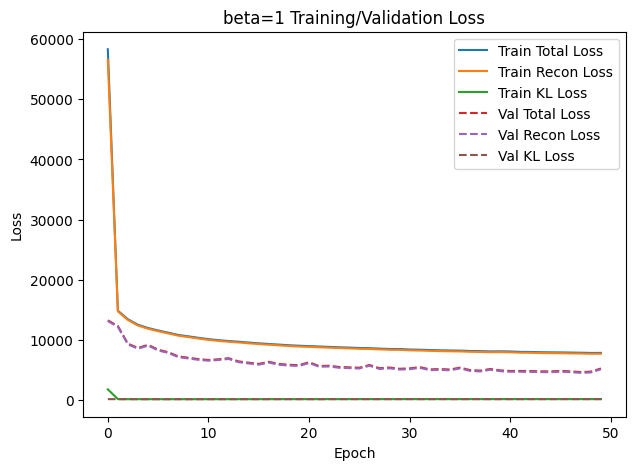

Computing MI matrix: 100%|██████████| 5/5 [00:00<00:00, 29.06it/s]

MIG (beta=1): 0.0001
MIG per factor (beta=1):
  shape: 0.0000
  scale: 0.0000
  orientation: 0.0001
  posX: 0.0002
  posY: 0.0002


In [ ]:
beta = 1
print(f"\n=== Training beta-VAE (beta={beta}) ===")

encoder = encoder_model(input_shape, filters, dense_h, latent_dim)
decoder = decoder_model(latent_dim, conv_feat_shape, filters)

vae_beta1 = VAE(encoder, decoder, beta)
vae_beta1.compile(optimizer=Adam(learning_rate, clipvalue=1.0))

progress_cb = EpochProgressBar(total_epochs=epochs)
history_beta1 = vae_beta1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[progress_cb],
    verbose=0
).history

plt.figure(figsize=(7,5))
plt.plot(history_beta1["total_loss"], label="Train Total Loss")
plt.plot(history_beta1["reconstruction_loss"], label="Train Recon Loss")
plt.plot(history_beta1["kl_loss"], label="Train KL Loss")

if "val_total_loss" in history_beta1:
    plt.plot(history_beta1["val_total_loss"], '--', label="Val Total Loss")
    plt.plot(history_beta1["val_reconstruction_loss"], '--', label="Val Recon Loss")
    plt.plot(history_beta1["val_kl_loss"], '--', label="Val KL Loss")

plt.title("beta=1 Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

vae_beta1.save("vae_beta1.keras")



latent_means_1 = vae_beta1.encode(val_ds)
factors_val = latents_classes[:len(latent_means_1), 1:]
mig_1, mig_per_factor_1 = compute_MIG(latent_means_1, factors_val)
print(f"MIG (beta=1): {mig_1:.4f}")

factor_names = metadata['latents_names'][1:]
print("MIG per factor (beta=1):")
for i, factor_name in enumerate(factor_names):
    print(f"  {factor_name}: {mig_per_factor_1[i]:.4f}")

beta = 1 Reconstructions


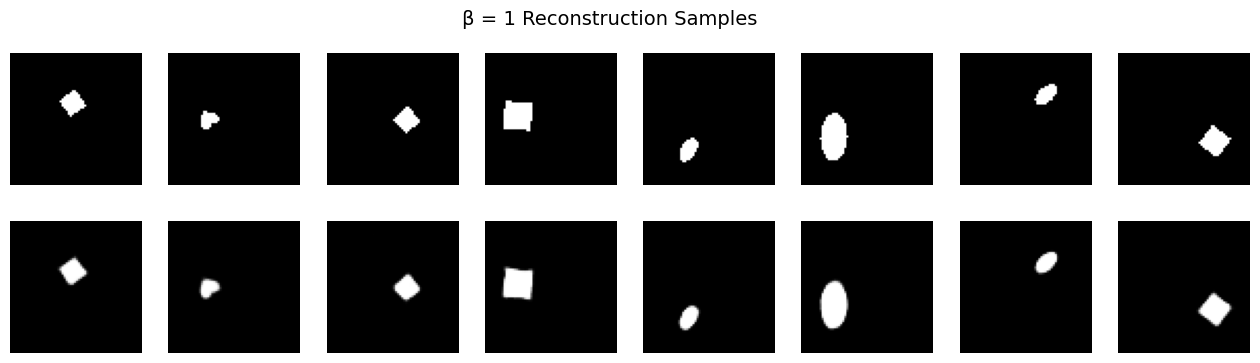

In [ ]:
print("beta = 1 Reconstructions")
show_reconstructions(vae_beta1, val_ds, beta_value=1)


In [ ]:
del vae_beta1, encoder, decoder
K.clear_session()
gc.collect()


0

# 9. Train(beta 5)


=== Training beta-VAE (beta=5) ===


Epochs:   2%|▏         | 1/50 [01:09<57:03, 69.87s/epoch, loss=54680.8242, recon=54018.6523, kl=132.4406, val=11887.1992]

Epoch 1/50 - loss: 54680.8242 - recon_loss: 54018.6523 - kl_loss: 132.4406 - val_loss: 11887.1992


Epochs:   4%|▍         | 2/50 [01:55<44:41, 55.87s/epoch, loss=14964.7607, recon=14470.1523, kl=98.9211, val=10307.9326] 

Epoch 2/50 - loss: 14964.7607 - recon_loss: 14470.1523 - kl_loss: 98.9211 - val_loss: 10307.9326


Epochs:   6%|▌         | 3/50 [02:41<40:14, 51.38s/epoch, loss=13604.4473, recon=13140.4346, kl=92.8021, val=11224.3516]

Epoch 3/50 - loss: 13604.4473 - recon_loss: 13140.4346 - kl_loss: 92.8021 - val_loss: 11224.3516


Epochs:   8%|▊         | 4/50 [03:27<37:46, 49.26s/epoch, loss=12760.2705, recon=12316.3145, kl=88.7901, val=9335.3730] 

Epoch 4/50 - loss: 12760.2705 - recon_loss: 12316.3145 - kl_loss: 88.7901 - val_loss: 9335.3730


Epochs:  10%|█         | 5/50 [04:14<36:04, 48.10s/epoch, loss=12110.6689, recon=11684.1201, kl=85.3099, val=8242.5273]

Epoch 5/50 - loss: 12110.6689 - recon_loss: 11684.1201 - kl_loss: 85.3099 - val_loss: 8242.5273


Epochs:  12%|█▏        | 6/50 [05:00<34:45, 47.40s/epoch, loss=11609.4453, recon=11193.0312, kl=83.2855, val=7966.7944]

Epoch 6/50 - loss: 11609.4453 - recon_loss: 11193.0312 - kl_loss: 83.2855 - val_loss: 7966.7944


Epochs:  14%|█▍        | 7/50 [05:46<33:38, 46.95s/epoch, loss=11314.8721, recon=10905.2119, kl=81.9330, val=8401.0176]

Epoch 7/50 - loss: 11314.8721 - recon_loss: 10905.2119 - kl_loss: 81.9330 - val_loss: 8401.0176


Epochs:  16%|█▌        | 8/50 [06:32<32:39, 46.66s/epoch, loss=10945.5303, recon=10541.1445, kl=80.8792, val=7348.3618]

Epoch 8/50 - loss: 10945.5303 - recon_loss: 10541.1445 - kl_loss: 80.8792 - val_loss: 7348.3618


Epochs:  18%|█▊        | 9/50 [07:18<31:45, 46.47s/epoch, loss=10693.1211, recon=10291.4619, kl=80.3324, val=7171.4326]

Epoch 9/50 - loss: 10693.1211 - recon_loss: 10291.4619 - kl_loss: 80.3324 - val_loss: 7171.4326


Epochs:  20%|██        | 10/50 [08:04<30:53, 46.34s/epoch, loss=10463.6475, recon=10064.1699, kl=79.8948, val=7028.9829]

Epoch 10/50 - loss: 10463.6475 - recon_loss: 10064.1699 - kl_loss: 79.8948 - val_loss: 7028.9829


Epochs:  22%|██▏       | 11/50 [08:50<30:03, 46.25s/epoch, loss=10274.6289, recon=9876.1953, kl=79.6870, val=7177.3623] 

Epoch 11/50 - loss: 10274.6289 - recon_loss: 9876.1953 - kl_loss: 79.6870 - val_loss: 7177.3623


Epochs:  24%|██▍       | 12/50 [09:36<29:15, 46.19s/epoch, loss=10113.9941, recon=9714.7178, kl=79.8557, val=6607.4077]

Epoch 12/50 - loss: 10113.9941 - recon_loss: 9714.7178 - kl_loss: 79.8557 - val_loss: 6607.4077


Epochs:  26%|██▌       | 13/50 [10:22<28:26, 46.13s/epoch, loss=10001.8213, recon=9603.4033, kl=79.6842, val=6597.6147]

Epoch 13/50 - loss: 10001.8213 - recon_loss: 9603.4033 - kl_loss: 79.6842 - val_loss: 6597.6147


Epochs:  28%|██▊       | 14/50 [11:08<27:39, 46.10s/epoch, loss=9818.4883, recon=9419.8018, kl=79.7379, val=6452.3433] 

Epoch 14/50 - loss: 9818.4883 - recon_loss: 9419.8018 - kl_loss: 79.7379 - val_loss: 6452.3433


Epochs:  30%|███       | 15/50 [11:54<26:52, 46.08s/epoch, loss=9694.3125, recon=9297.1914, kl=79.4248, val=6208.0859]

Epoch 15/50 - loss: 9694.3125 - recon_loss: 9297.1914 - kl_loss: 79.4248 - val_loss: 6208.0859


Epochs:  32%|███▏      | 16/50 [12:40<26:06, 46.06s/epoch, loss=9603.6680, recon=9207.4102, kl=79.2514, val=6465.9038]

Epoch 16/50 - loss: 9603.6680 - recon_loss: 9207.4102 - kl_loss: 79.2514 - val_loss: 6465.9038


Epochs:  34%|███▍      | 17/50 [13:26<25:19, 46.05s/epoch, loss=9471.1133, recon=9074.2158, kl=79.3804, val=6204.6377]

Epoch 17/50 - loss: 9471.1133 - recon_loss: 9074.2158 - kl_loss: 79.3804 - val_loss: 6204.6377


Epochs:  36%|███▌      | 18/50 [14:12<24:33, 46.05s/epoch, loss=9384.4355, recon=8988.4141, kl=79.2028, val=6118.5518]

Epoch 18/50 - loss: 9384.4355 - recon_loss: 8988.4141 - kl_loss: 79.2028 - val_loss: 6118.5518


Epochs:  38%|███▊      | 19/50 [14:58<23:47, 46.04s/epoch, loss=9335.3008, recon=8940.0391, kl=79.0523, val=6108.9438]

Epoch 19/50 - loss: 9335.3008 - recon_loss: 8940.0391 - kl_loss: 79.0523 - val_loss: 6108.9438


Epochs:  40%|████      | 20/50 [15:44<23:01, 46.04s/epoch, loss=9220.4062, recon=8824.6143, kl=79.1583, val=5897.3394]

Epoch 20/50 - loss: 9220.4062 - recon_loss: 8824.6143 - kl_loss: 79.1583 - val_loss: 5897.3394


Epochs:  42%|████▏     | 21/50 [16:31<22:20, 46.22s/epoch, loss=9157.3574, recon=8761.8604, kl=79.0989, val=6282.3389]

Epoch 21/50 - loss: 9157.3574 - recon_loss: 8761.8604 - kl_loss: 79.0989 - val_loss: 6282.3389


Epochs:  44%|████▍     | 22/50 [17:17<21:38, 46.37s/epoch, loss=9087.2900, recon=8692.9561, kl=78.8675, val=6275.0337]

Epoch 22/50 - loss: 9087.2900 - recon_loss: 8692.9561 - kl_loss: 78.8675 - val_loss: 6275.0337


Epochs:  46%|████▌     | 23/50 [18:04<20:56, 46.52s/epoch, loss=9034.6357, recon=8642.1914, kl=78.4871, val=5802.6924]

Epoch 23/50 - loss: 9034.6357 - recon_loss: 8642.1914 - kl_loss: 78.4871 - val_loss: 5802.6924


Epochs:  48%|████▊     | 24/50 [18:51<20:10, 46.55s/epoch, loss=8991.3105, recon=8598.7930, kl=78.5031, val=5729.4048]

Epoch 24/50 - loss: 8991.3105 - recon_loss: 8598.7930 - kl_loss: 78.5031 - val_loss: 5729.4048


Epochs:  50%|█████     | 25/50 [19:37<19:23, 46.55s/epoch, loss=8895.5898, recon=8503.0029, kl=78.5185, val=5657.1641]

Epoch 25/50 - loss: 8895.5898 - recon_loss: 8503.0029 - kl_loss: 78.5185 - val_loss: 5657.1641


Epochs:  52%|█████▏    | 26/50 [20:24<18:34, 46.43s/epoch, loss=8877.0225, recon=8484.6133, kl=78.4811, val=5628.6753]

Epoch 26/50 - loss: 8877.0225 - recon_loss: 8484.6133 - kl_loss: 78.4811 - val_loss: 5628.6753


Epochs:  54%|█████▍    | 27/50 [21:10<17:45, 46.32s/epoch, loss=8848.5361, recon=8456.4355, kl=78.4203, val=5599.6709]

Epoch 27/50 - loss: 8848.5361 - recon_loss: 8456.4355 - kl_loss: 78.4203 - val_loss: 5599.6709


Epochs:  56%|█████▌    | 28/50 [21:56<16:57, 46.24s/epoch, loss=8779.0352, recon=8388.8652, kl=78.0341, val=5594.1831]

Epoch 28/50 - loss: 8779.0352 - recon_loss: 8388.8652 - kl_loss: 78.0341 - val_loss: 5594.1831


Epochs:  58%|█████▊    | 29/50 [22:42<16:09, 46.18s/epoch, loss=8737.9121, recon=8345.0996, kl=78.5629, val=5482.6089]

Epoch 29/50 - loss: 8737.9121 - recon_loss: 8345.0996 - kl_loss: 78.5629 - val_loss: 5482.6089


Epochs:  60%|██████    | 30/50 [23:28<15:22, 46.15s/epoch, loss=8678.2910, recon=8287.1250, kl=78.2352, val=5471.3628]

Epoch 30/50 - loss: 8678.2910 - recon_loss: 8287.1250 - kl_loss: 78.2352 - val_loss: 5471.3628


Epochs:  62%|██████▏   | 31/50 [24:14<14:36, 46.12s/epoch, loss=8629.2842, recon=8237.7871, kl=78.2990, val=5388.5396]

Epoch 31/50 - loss: 8629.2842 - recon_loss: 8237.7871 - kl_loss: 78.2990 - val_loss: 5388.5396


Epochs:  64%|██████▍   | 32/50 [25:00<13:49, 46.09s/epoch, loss=8599.9414, recon=8210.1729, kl=77.9531, val=5380.4448]

Epoch 32/50 - loss: 8599.9414 - recon_loss: 8210.1729 - kl_loss: 77.9531 - val_loss: 5380.4448


Epochs:  66%|██████▌   | 33/50 [25:46<13:03, 46.08s/epoch, loss=8563.7041, recon=8175.2539, kl=77.6900, val=5399.4375]

Epoch 33/50 - loss: 8563.7041 - recon_loss: 8175.2539 - kl_loss: 77.6900 - val_loss: 5399.4375


Epochs:  68%|██████▊   | 34/50 [26:32<12:17, 46.08s/epoch, loss=8520.0967, recon=8132.6284, kl=77.4938, val=5871.6655]

Epoch 34/50 - loss: 8520.0967 - recon_loss: 8132.6284 - kl_loss: 77.4938 - val_loss: 5871.6655


Epochs:  70%|███████   | 35/50 [27:18<11:30, 46.06s/epoch, loss=8486.0908, recon=8098.5806, kl=77.5020, val=5406.7773]

Epoch 35/50 - loss: 8486.0908 - recon_loss: 8098.5806 - kl_loss: 77.5020 - val_loss: 5406.7773


Epochs:  72%|███████▏  | 36/50 [28:04<10:44, 46.06s/epoch, loss=8458.4902, recon=8070.0264, kl=77.6922, val=5433.3218]

Epoch 36/50 - loss: 8458.4902 - recon_loss: 8070.0264 - kl_loss: 77.6922 - val_loss: 5433.3218


Epochs:  74%|███████▍  | 37/50 [28:50<09:58, 46.06s/epoch, loss=8430.6689, recon=8041.0444, kl=77.9240, val=5553.8467]

Epoch 37/50 - loss: 8430.6689 - recon_loss: 8041.0444 - kl_loss: 77.9240 - val_loss: 5553.8467


Epochs:  76%|███████▌  | 38/50 [29:36<09:12, 46.05s/epoch, loss=8384.6729, recon=7996.4951, kl=77.6359, val=5187.6367]

Epoch 38/50 - loss: 8384.6729 - recon_loss: 7996.4951 - kl_loss: 77.6359 - val_loss: 5187.6367


Epochs:  78%|███████▊  | 39/50 [30:22<08:26, 46.05s/epoch, loss=8359.1426, recon=7972.9097, kl=77.2461, val=5334.3428]

Epoch 39/50 - loss: 8359.1426 - recon_loss: 7972.9097 - kl_loss: 77.2461 - val_loss: 5334.3428


Epochs:  80%|████████  | 40/50 [31:08<07:40, 46.05s/epoch, loss=8346.8340, recon=7961.3643, kl=77.0943, val=5197.8608]

Epoch 40/50 - loss: 8346.8340 - recon_loss: 7961.3643 - kl_loss: 77.0943 - val_loss: 5197.8608


Epochs:  82%|████████▏ | 41/50 [31:54<06:54, 46.05s/epoch, loss=8307.6748, recon=7922.4468, kl=77.0460, val=5368.3843]

Epoch 41/50 - loss: 8307.6748 - recon_loss: 7922.4468 - kl_loss: 77.0460 - val_loss: 5368.3843


Epochs:  84%|████████▍ | 42/50 [32:40<06:08, 46.04s/epoch, loss=8277.7256, recon=7893.5728, kl=76.8316, val=5093.9287]

Epoch 42/50 - loss: 8277.7256 - recon_loss: 7893.5728 - kl_loss: 76.8316 - val_loss: 5093.9287


Epochs:  86%|████████▌ | 43/50 [33:26<05:22, 46.05s/epoch, loss=8270.4326, recon=7887.8535, kl=76.5164, val=5167.6724]

Epoch 43/50 - loss: 8270.4326 - recon_loss: 7887.8535 - kl_loss: 76.5164 - val_loss: 5167.6724


Epochs:  88%|████████▊ | 44/50 [34:12<04:36, 46.04s/epoch, loss=8207.6963, recon=7824.5840, kl=76.6212, val=5236.9292]

Epoch 44/50 - loss: 8207.6963 - recon_loss: 7824.5840 - kl_loss: 76.6212 - val_loss: 5236.9292


Epochs:  90%|█████████ | 45/50 [34:58<03:50, 46.04s/epoch, loss=8189.2495, recon=7806.5889, kl=76.5340, val=5174.0322]

Epoch 45/50 - loss: 8189.2495 - recon_loss: 7806.5889 - kl_loss: 76.5340 - val_loss: 5174.0322


Epochs:  92%|█████████▏| 46/50 [35:45<03:04, 46.04s/epoch, loss=8166.1152, recon=7784.5605, kl=76.3111, val=5284.3516]

Epoch 46/50 - loss: 8166.1152 - recon_loss: 7784.5605 - kl_loss: 76.3111 - val_loss: 5284.3516


Epochs:  94%|█████████▍| 47/50 [36:31<02:18, 46.03s/epoch, loss=8157.9805, recon=7777.0029, kl=76.1960, val=5021.9971]

Epoch 47/50 - loss: 8157.9805 - recon_loss: 7777.0029 - kl_loss: 76.1960 - val_loss: 5021.9971


Epochs:  96%|█████████▌| 48/50 [37:17<01:32, 46.03s/epoch, loss=8136.5859, recon=7754.5503, kl=76.4077, val=5074.7905]

Epoch 48/50 - loss: 8136.5859 - recon_loss: 7754.5503 - kl_loss: 76.4077 - val_loss: 5074.7905


Epochs:  98%|█████████▊| 49/50 [38:03<00:46, 46.04s/epoch, loss=8131.2129, recon=7749.5254, kl=76.3373, val=5093.2827]

Epoch 49/50 - loss: 8131.2129 - recon_loss: 7749.5254 - kl_loss: 76.3373 - val_loss: 5093.2827


Epochs: 100%|██████████| 50/50 [38:49<00:00, 46.58s/epoch, loss=8096.7852, recon=7716.1821, kl=76.1209, val=5045.0908]

Epoch 50/50 - loss: 8096.7852 - recon_loss: 7716.1821 - kl_loss: 76.1209 - val_loss: 5045.0908


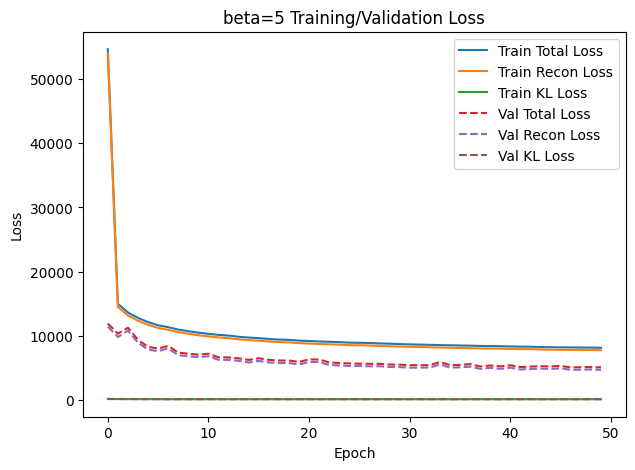

Computing MI matrix: 100%|██████████| 5/5 [00:00<00:00, 38.00it/s]

MIG (beta=5): 0.0002
MIG per factor (beta=5):
  shape: 0.0000
  scale: 0.0000
  orientation: 0.0001
  posX: 0.0008
  posY: 0.0002


In [ ]:
beta = 5
print(f"\n=== Training beta-VAE (beta={beta}) ===")

encoder = encoder_model(input_shape, filters, dense_h, latent_dim)
decoder = decoder_model(latent_dim, conv_feat_shape, filters)

vae_beta5 = VAE(encoder, decoder, beta)
vae_beta5.compile(optimizer=Adam(learning_rate, clipvalue=1.0))

progress_cb = EpochProgressBar(total_epochs=epochs)
history_beta5 = vae_beta5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[progress_cb],
    verbose=0
).history

plt.figure(figsize=(7,5))
plt.plot(history_beta5["total_loss"], label="Train Total Loss")
plt.plot(history_beta5["reconstruction_loss"], label="Train Recon Loss")
plt.plot(history_beta5["kl_loss"], label="Train KL Loss")

if "val_total_loss" in history_beta5:
    plt.plot(history_beta5["val_total_loss"], '--', label="Val Total Loss")
    plt.plot(history_beta5["val_reconstruction_loss"], '--', label="Val Recon Loss")
    plt.plot(history_beta5["val_kl_loss"], '--', label="Val KL Loss")

plt.title("beta=5 Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

vae_beta5.save("vae_beta5.keras")
latent_means_5 = vae_beta5.encode(val_ds)
factors_val = latents_classes[:len(latent_means_5), 1:]
mig_5, mig_per_factor_5 = compute_MIG(latent_means_5, factors_val)
print(f"MIG (beta=5): {mig_5:.4f}")

factor_names = metadata['latents_names'][1:]
print("MIG per factor (beta=5):")
for i, factor_name in enumerate(factor_names):
    print(f"  {factor_name}: {mig_per_factor_5[i]:.4f}")

beta = 5 Reconstructions


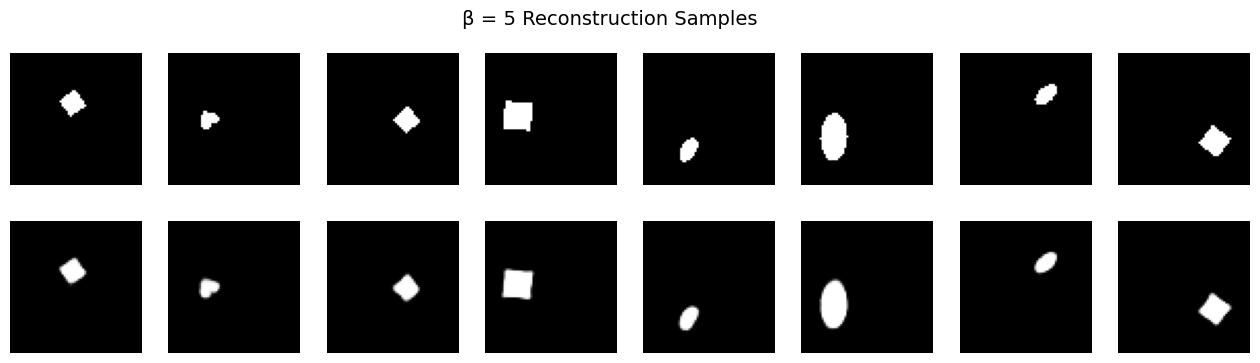

In [ ]:
print("beta = 5 Reconstructions")
show_reconstructions(vae_beta5, val_ds, beta_value=5)

In [ ]:
del vae_beta5, encoder, decoder
K.clear_session()
gc.collect()


0

# 10. Train(beta 10)


=== Training beta-VAE (beta=10) ===


Epochs:   2%|▏         | 1/50 [01:10<57:40, 70.63s/epoch, loss=68055.8203, recon=67076.6562, kl=97.9290, val=17598.4141]

Epoch 1/50 - loss: 68055.8203 - recon_loss: 67076.6562 - kl_loss: 97.9290 - val_loss: 17598.4141


Epochs:   4%|▍         | 2/50 [01:57<45:15, 56.57s/epoch, loss=17584.5859, recon=16762.6055, kl=82.1983, val=13288.1455]

Epoch 2/50 - loss: 17584.5859 - recon_loss: 16762.6055 - kl_loss: 82.1983 - val_loss: 13288.1455


Epochs:   6%|▌         | 3/50 [02:44<40:53, 52.21s/epoch, loss=14968.4443, recon=14215.9785, kl=75.2465, val=10983.8164]

Epoch 3/50 - loss: 14968.4443 - recon_loss: 14215.9785 - kl_loss: 75.2465 - val_loss: 10983.8164


Epochs:   8%|▊         | 4/50 [03:31<38:25, 50.11s/epoch, loss=13717.9033, recon=13009.2695, kl=70.8642, val=9633.3535] 

Epoch 4/50 - loss: 13717.9033 - recon_loss: 13009.2695 - kl_loss: 70.8642 - val_loss: 9633.3535


Epochs:  10%|█         | 5/50 [04:18<36:44, 49.00s/epoch, loss=12855.1348, recon=12173.2344, kl=68.1901, val=9376.4170]

Epoch 5/50 - loss: 12855.1348 - recon_loss: 12173.2344 - kl_loss: 68.1901 - val_loss: 9376.4170


Epochs:  12%|█▏        | 6/50 [05:04<35:21, 48.21s/epoch, loss=12194.0273, recon=11526.6309, kl=66.7385, val=8706.1543]

Epoch 6/50 - loss: 12194.0273 - recon_loss: 11526.6309 - kl_loss: 66.7385 - val_loss: 8706.1543


Epochs:  14%|█▍        | 7/50 [05:51<34:02, 47.50s/epoch, loss=11662.6660, recon=11003.7939, kl=65.8875, val=8376.7871]

Epoch 7/50 - loss: 11662.6660 - recon_loss: 11003.7939 - kl_loss: 65.8875 - val_loss: 8376.7871


Epochs:  16%|█▌        | 8/50 [06:37<32:56, 47.06s/epoch, loss=11263.9053, recon=10609.4492, kl=65.4452, val=7860.2227]

Epoch 8/50 - loss: 11263.9053 - recon_loss: 10609.4492 - kl_loss: 65.4452 - val_loss: 7860.2227


Epochs:  18%|█▊        | 9/50 [07:23<31:55, 46.73s/epoch, loss=10906.8916, recon=10255.0117, kl=65.1884, val=7315.0337]

Epoch 9/50 - loss: 10906.8916 - recon_loss: 10255.0117 - kl_loss: 65.1884 - val_loss: 7315.0337


Epochs:  20%|██        | 10/50 [08:09<31:00, 46.52s/epoch, loss=10618.2520, recon=9967.3896, kl=65.0871, val=7361.6758] 

Epoch 10/50 - loss: 10618.2520 - recon_loss: 9967.3896 - kl_loss: 65.0871 - val_loss: 7361.6758


Epochs:  22%|██▏       | 11/50 [08:55<30:08, 46.37s/epoch, loss=10326.4326, recon=9677.9551, kl=64.8489, val=6903.1548]

Epoch 11/50 - loss: 10326.4326 - recon_loss: 9677.9551 - kl_loss: 64.8489 - val_loss: 6903.1548


Epochs:  24%|██▍       | 12/50 [09:41<29:18, 46.29s/epoch, loss=10119.3818, recon=9470.3750, kl=64.9004, val=6730.9072]

Epoch 12/50 - loss: 10119.3818 - recon_loss: 9470.3750 - kl_loss: 64.9004 - val_loss: 6730.9072


Epochs:  26%|██▌       | 13/50 [10:27<28:30, 46.23s/epoch, loss=9916.9785, recon=9270.2734, kl=64.6706, val=6358.2065] 

Epoch 13/50 - loss: 9916.9785 - recon_loss: 9270.2734 - kl_loss: 64.6706 - val_loss: 6358.2065


Epochs:  28%|██▊       | 14/50 [11:13<27:43, 46.21s/epoch, loss=9775.5352, recon=9130.6055, kl=64.4926, val=6399.7104]

Epoch 14/50 - loss: 9775.5352 - recon_loss: 9130.6055 - kl_loss: 64.4926 - val_loss: 6399.7104


Epochs:  30%|███       | 15/50 [11:59<26:55, 46.17s/epoch, loss=9595.9600, recon=8950.7344, kl=64.5217, val=6312.7852]

Epoch 15/50 - loss: 9595.9600 - recon_loss: 8950.7344 - kl_loss: 64.5217 - val_loss: 6312.7852


Epochs:  32%|███▏      | 16/50 [12:45<26:08, 46.13s/epoch, loss=9418.1982, recon=8774.0791, kl=64.4114, val=6128.1670]

Epoch 16/50 - loss: 9418.1982 - recon_loss: 8774.0791 - kl_loss: 64.4114 - val_loss: 6128.1670


Epochs:  34%|███▍      | 17/50 [13:31<25:21, 46.10s/epoch, loss=9341.1270, recon=8699.0322, kl=64.2096, val=6551.2490]

Epoch 17/50 - loss: 9341.1270 - recon_loss: 8699.0322 - kl_loss: 64.2096 - val_loss: 6551.2490


Epochs:  36%|███▌      | 18/50 [14:17<24:34, 46.07s/epoch, loss=9258.4355, recon=8617.9707, kl=64.0460, val=6128.5073]

Epoch 18/50 - loss: 9258.4355 - recon_loss: 8617.9707 - kl_loss: 64.0460 - val_loss: 6128.5073


Epochs:  38%|███▊      | 19/50 [15:03<23:48, 46.07s/epoch, loss=9130.8145, recon=8492.5840, kl=63.8224, val=5937.5200]

Epoch 19/50 - loss: 9130.8145 - recon_loss: 8492.5840 - kl_loss: 63.8224 - val_loss: 5937.5200


Epochs:  40%|████      | 20/50 [15:49<23:02, 46.09s/epoch, loss=9045.5195, recon=8408.6094, kl=63.6904, val=5850.1260]

Epoch 20/50 - loss: 9045.5195 - recon_loss: 8408.6094 - kl_loss: 63.6904 - val_loss: 5850.1260


Epochs:  42%|████▏     | 21/50 [16:35<22:15, 46.06s/epoch, loss=8949.3662, recon=8314.5977, kl=63.4765, val=5698.8398]

Epoch 21/50 - loss: 8949.3662 - recon_loss: 8314.5977 - kl_loss: 63.4765 - val_loss: 5698.8398


Epochs:  44%|████▍     | 22/50 [17:21<21:29, 46.06s/epoch, loss=8842.6680, recon=8208.6133, kl=63.4056, val=5654.0693]

Epoch 22/50 - loss: 8842.6680 - recon_loss: 8208.6133 - kl_loss: 63.4056 - val_loss: 5654.0693


Epochs:  46%|████▌     | 23/50 [18:08<20:43, 46.05s/epoch, loss=8772.5850, recon=8139.9009, kl=63.2686, val=5642.1948]

Epoch 23/50 - loss: 8772.5850 - recon_loss: 8139.9009 - kl_loss: 63.2686 - val_loss: 5642.1948


Epochs:  48%|████▊     | 24/50 [18:54<19:57, 46.04s/epoch, loss=8708.1240, recon=8076.9199, kl=63.1201, val=5624.2881]

Epoch 24/50 - loss: 8708.1240 - recon_loss: 8076.9199 - kl_loss: 63.1201 - val_loss: 5624.2881


Epochs:  50%|█████     | 25/50 [19:40<19:11, 46.04s/epoch, loss=8664.8691, recon=8035.0771, kl=62.9784, val=5528.5342]

Epoch 25/50 - loss: 8664.8691 - recon_loss: 8035.0771 - kl_loss: 62.9784 - val_loss: 5528.5342


Epochs:  52%|█████▏    | 26/50 [20:26<18:25, 46.05s/epoch, loss=8593.2520, recon=7965.5288, kl=62.7730, val=5582.8374]

Epoch 26/50 - loss: 8593.2520 - recon_loss: 7965.5288 - kl_loss: 62.7730 - val_loss: 5582.8374


Epochs:  54%|█████▍    | 27/50 [21:12<17:39, 46.07s/epoch, loss=8533.2754, recon=7907.1133, kl=62.6167, val=5406.8330]

Epoch 27/50 - loss: 8533.2754 - recon_loss: 7907.1133 - kl_loss: 62.6167 - val_loss: 5406.8330


Epochs:  56%|█████▌    | 28/50 [21:58<16:53, 46.06s/epoch, loss=8517.2344, recon=7891.1270, kl=62.6105, val=5383.9502]

Epoch 28/50 - loss: 8517.2344 - recon_loss: 7891.1270 - kl_loss: 62.6105 - val_loss: 5383.9502


Epochs:  58%|█████▊    | 29/50 [22:44<16:07, 46.06s/epoch, loss=8454.2148, recon=7831.0103, kl=62.3209, val=5431.4780]

Epoch 29/50 - loss: 8454.2148 - recon_loss: 7831.0103 - kl_loss: 62.3209 - val_loss: 5431.4780


Epochs:  60%|██████    | 30/50 [23:30<15:21, 46.05s/epoch, loss=8357.4424, recon=7734.0874, kl=62.3345, val=5270.6260]

Epoch 30/50 - loss: 8357.4424 - recon_loss: 7734.0874 - kl_loss: 62.3345 - val_loss: 5270.6260


Epochs:  62%|██████▏   | 31/50 [24:16<14:34, 46.05s/epoch, loss=8338.5322, recon=7717.0835, kl=62.1449, val=5341.9932]

Epoch 31/50 - loss: 8338.5322 - recon_loss: 7717.0835 - kl_loss: 62.1449 - val_loss: 5341.9932


Epochs:  64%|██████▍   | 32/50 [25:02<13:48, 46.05s/epoch, loss=8314.2676, recon=7696.2583, kl=61.8014, val=5263.3726]

Epoch 32/50 - loss: 8314.2676 - recon_loss: 7696.2583 - kl_loss: 61.8014 - val_loss: 5263.3726


Epochs:  66%|██████▌   | 33/50 [25:48<13:03, 46.06s/epoch, loss=8245.9922, recon=7627.5229, kl=61.8467, val=5184.2656]

Epoch 33/50 - loss: 8245.9922 - recon_loss: 7627.5229 - kl_loss: 61.8467 - val_loss: 5184.2656


Epochs:  68%|██████▊   | 34/50 [26:34<12:18, 46.13s/epoch, loss=8230.2959, recon=7611.9873, kl=61.8304, val=5251.3228]

Epoch 34/50 - loss: 8230.2959 - recon_loss: 7611.9873 - kl_loss: 61.8304 - val_loss: 5251.3228


Epochs:  70%|███████   | 35/50 [27:20<11:31, 46.11s/epoch, loss=8214.7236, recon=7598.7222, kl=61.6005, val=5331.6255]

Epoch 35/50 - loss: 8214.7236 - recon_loss: 7598.7222 - kl_loss: 61.6005 - val_loss: 5331.6255


Epochs:  72%|███████▏  | 36/50 [28:06<10:45, 46.09s/epoch, loss=8166.4907, recon=7550.9062, kl=61.5585, val=5143.6484]

Epoch 36/50 - loss: 8166.4907 - recon_loss: 7550.9062 - kl_loss: 61.5585 - val_loss: 5143.6484


Epochs:  74%|███████▍  | 37/50 [28:52<09:58, 46.07s/epoch, loss=8115.6187, recon=7500.2939, kl=61.5324, val=5194.9497]

Epoch 37/50 - loss: 8115.6187 - recon_loss: 7500.2939 - kl_loss: 61.5324 - val_loss: 5194.9497


Epochs:  76%|███████▌  | 38/50 [29:39<09:12, 46.07s/epoch, loss=8116.9092, recon=7502.7295, kl=61.4178, val=5030.8623]

Epoch 38/50 - loss: 8116.9092 - recon_loss: 7502.7295 - kl_loss: 61.4178 - val_loss: 5030.8623


Epochs:  78%|███████▊  | 39/50 [30:25<08:26, 46.07s/epoch, loss=8040.9302, recon=7428.0049, kl=61.2924, val=5083.3789]

Epoch 39/50 - loss: 8040.9302 - recon_loss: 7428.0049 - kl_loss: 61.2924 - val_loss: 5083.3789


Epochs:  80%|████████  | 40/50 [31:11<07:40, 46.05s/epoch, loss=8040.7051, recon=7428.5000, kl=61.2200, val=5149.4570]

Epoch 40/50 - loss: 8040.7051 - recon_loss: 7428.5000 - kl_loss: 61.2200 - val_loss: 5149.4570


Epochs:  82%|████████▏ | 41/50 [31:57<06:54, 46.05s/epoch, loss=8037.3501, recon=7425.0122, kl=61.2339, val=5153.7256]

Epoch 41/50 - loss: 8037.3501 - recon_loss: 7425.0122 - kl_loss: 61.2339 - val_loss: 5153.7256


Epochs:  84%|████████▍ | 42/50 [32:43<06:08, 46.06s/epoch, loss=7998.6919, recon=7387.9927, kl=61.0695, val=5030.9663]

Epoch 42/50 - loss: 7998.6919 - recon_loss: 7387.9927 - kl_loss: 61.0695 - val_loss: 5030.9663


Epochs:  86%|████████▌ | 43/50 [33:29<05:22, 46.05s/epoch, loss=7958.1846, recon=7347.6499, kl=61.0529, val=5064.7295]

Epoch 43/50 - loss: 7958.1846 - recon_loss: 7347.6499 - kl_loss: 61.0529 - val_loss: 5064.7295


Epochs:  88%|████████▊ | 44/50 [34:15<04:36, 46.04s/epoch, loss=7960.8896, recon=7350.7417, kl=61.0152, val=4911.8413]

Epoch 44/50 - loss: 7960.8896 - recon_loss: 7350.7417 - kl_loss: 61.0152 - val_loss: 4911.8413


Epochs:  90%|█████████ | 45/50 [35:01<03:50, 46.04s/epoch, loss=7919.9824, recon=7311.2646, kl=60.8718, val=5128.8916]

Epoch 45/50 - loss: 7919.9824 - recon_loss: 7311.2646 - kl_loss: 60.8718 - val_loss: 5128.8916


Epochs:  92%|█████████▏| 46/50 [35:47<03:04, 46.08s/epoch, loss=7898.6685, recon=7290.6445, kl=60.8030, val=4898.2119]

Epoch 46/50 - loss: 7898.6685 - recon_loss: 7290.6445 - kl_loss: 60.8030 - val_loss: 4898.2119


Epochs:  94%|█████████▍| 47/50 [36:33<02:18, 46.07s/epoch, loss=7854.7153, recon=7248.1206, kl=60.6596, val=4928.3916]

Epoch 47/50 - loss: 7854.7153 - recon_loss: 7248.1206 - kl_loss: 60.6596 - val_loss: 4928.3916


Epochs:  96%|█████████▌| 48/50 [37:19<01:32, 46.06s/epoch, loss=7848.4180, recon=7240.5591, kl=60.7859, val=5063.1411]

Epoch 48/50 - loss: 7848.4180 - recon_loss: 7240.5591 - kl_loss: 60.7859 - val_loss: 5063.1411


Epochs:  98%|█████████▊| 49/50 [38:05<00:46, 46.11s/epoch, loss=7811.0254, recon=7204.5732, kl=60.6449, val=4841.7036]

Epoch 49/50 - loss: 7811.0254 - recon_loss: 7204.5732 - kl_loss: 60.6449 - val_loss: 4841.7036


Epochs: 100%|██████████| 50/50 [38:51<00:00, 46.64s/epoch, loss=7783.6704, recon=7177.5005, kl=60.6168, val=4914.4282]

Epoch 50/50 - loss: 7783.6704 - recon_loss: 7177.5005 - kl_loss: 60.6168 - val_loss: 4914.4282


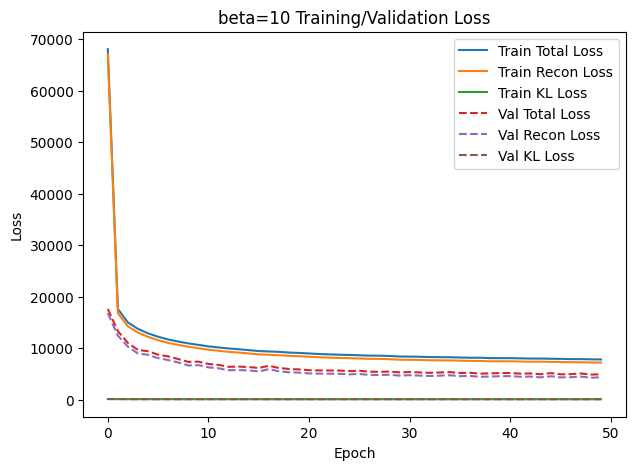

Computing MI matrix: 100%|██████████| 5/5 [00:00<00:00, 35.23it/s]

MIG (beta=10): 0.0003
MIG per factor (beta=10):
  shape: 0.0000
  scale: 0.0000
  orientation: 0.0005
  posX: 0.0005
  posY: 0.0005


In [ ]:
beta = 10
print(f"\n=== Training beta-VAE (beta={beta}) ===")

encoder = encoder_model(input_shape, filters, dense_h, latent_dim)
decoder = decoder_model(latent_dim, conv_feat_shape, filters)

vae_beta10 = VAE(encoder, decoder, beta)
vae_beta10.compile(optimizer=Adam(learning_rate))

progress_cb = EpochProgressBar(total_epochs=epochs)
history_beta10 = vae_beta10.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[progress_cb],
    verbose=0
).history

plt.figure(figsize=(7,5))
plt.plot(history_beta10["total_loss"], label="Train Total Loss")
plt.plot(history_beta10["reconstruction_loss"], label="Train Recon Loss")
plt.plot(history_beta10["kl_loss"], label="Train KL Loss")

if "val_total_loss" in history_beta10:
    plt.plot(history_beta10["val_total_loss"], '--', label="Val Total Loss")
    plt.plot(history_beta10["val_reconstruction_loss"], '--', label="Val Recon Loss")
    plt.plot(history_beta10["val_kl_loss"], '--', label="Val KL Loss")

plt.title("beta=10 Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

vae_beta10.save("vae_beta10.keras")
latent_means_10 = vae_beta10.encode(val_ds)
factors_val = latents_classes[:len(latent_means_10), 1:]
mig_10, mig_per_factor_10 = compute_MIG(latent_means_10, factors_val)
print(f"MIG (beta=10): {mig_10:.4f}")

factor_names = metadata['latents_names'][1:]
print("MIG per factor (beta=10):")
for i, factor_name in enumerate(factor_names):
    print(f"  {factor_name}: {mig_per_factor_10[i]:.4f}")

beta = 10 Reconstructions


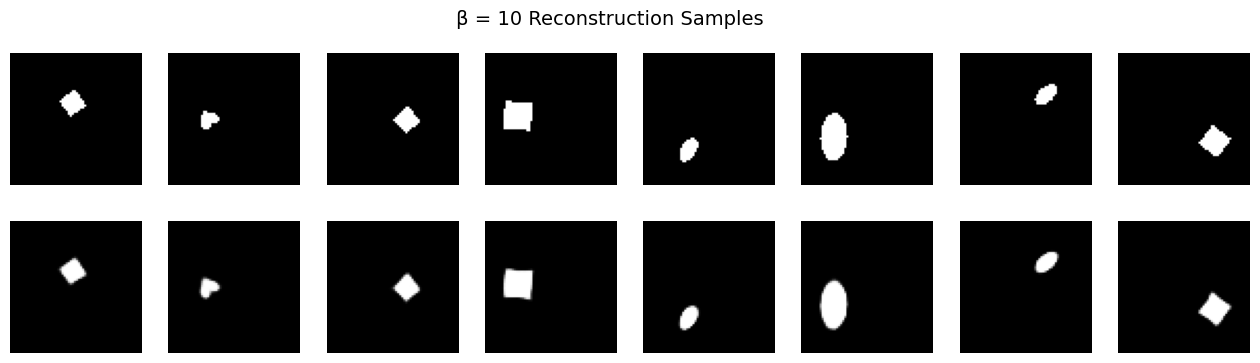

In [ ]:
print("beta = 10 Reconstructions")
show_reconstructions(vae_beta10, val_ds, beta_value=10)


In [ ]:
del vae_beta10, encoder, decoder
K.clear_session()
gc.collect()


0

# 11. MIG Visualization

beta=1: MIG=0.0001
beta=5: MIG=0.0002
beta=10: MIG=0.0003


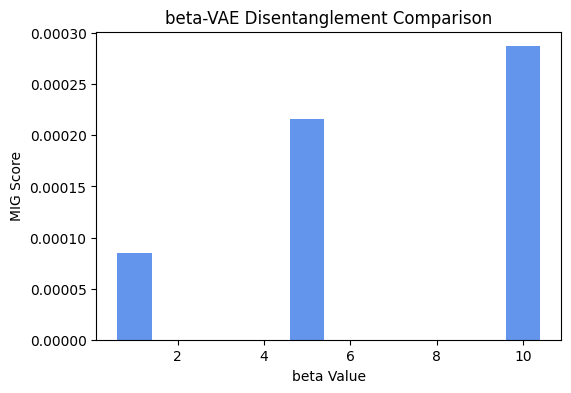

In [ ]:
mig_results = {
    1: mig_1,
    5: mig_5,
    10: mig_10
}

for beta, mig in mig_results.items():
    print(f"beta={beta}: MIG={mig:.4f}")

plt.figure(figsize=(6,4))
plt.bar(mig_results.keys(), mig_results.values(), color="cornflowerblue")
plt.xlabel("beta Value")
plt.ylabel("MIG Score")
plt.title("beta-VAE Disentanglement Comparison")
plt.show()


# 12. PCA

In [ ]:
def plot_pca_colored_by_factor(latent_means, factors, factor_index, factor_name):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_means)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.6, c=factors[:, factor_index], cmap='viridis')
    plt.title(f"Latent Space PCA (beta = 10) - Colored by {factor_name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, label=factor_name)
    plt.grid(True)
    plt.show()


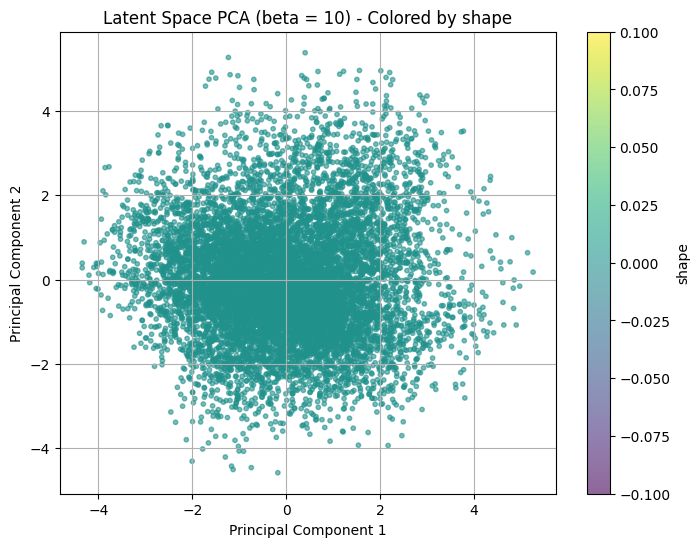

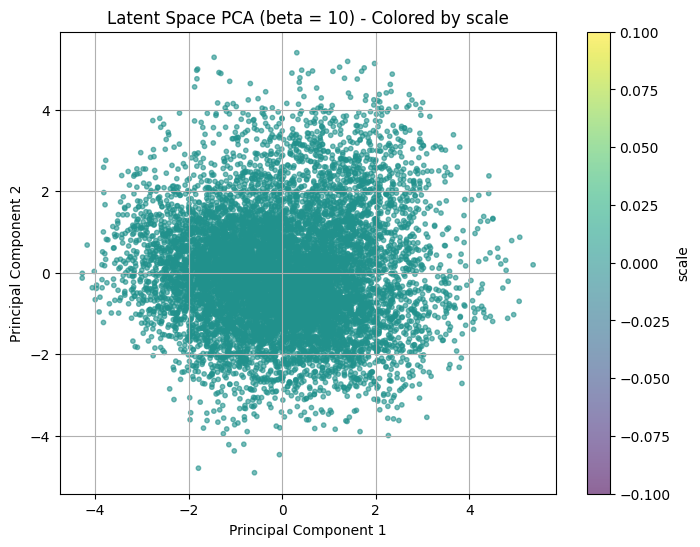

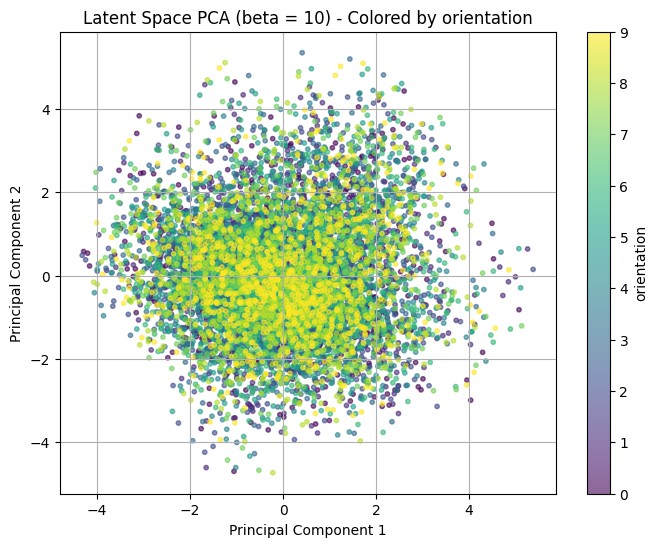

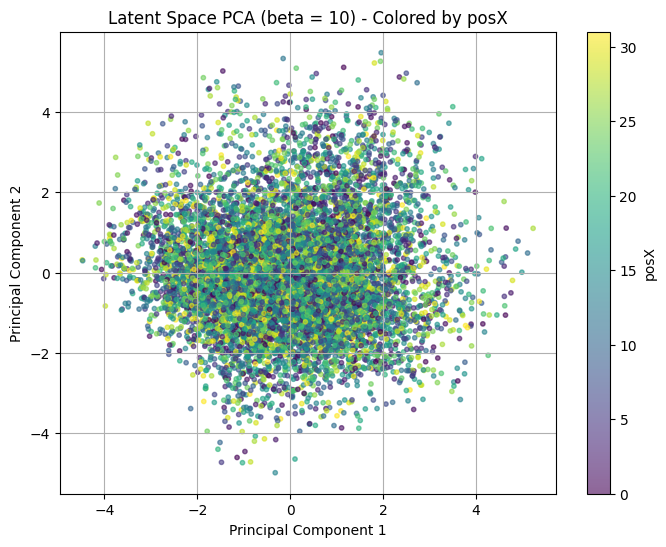

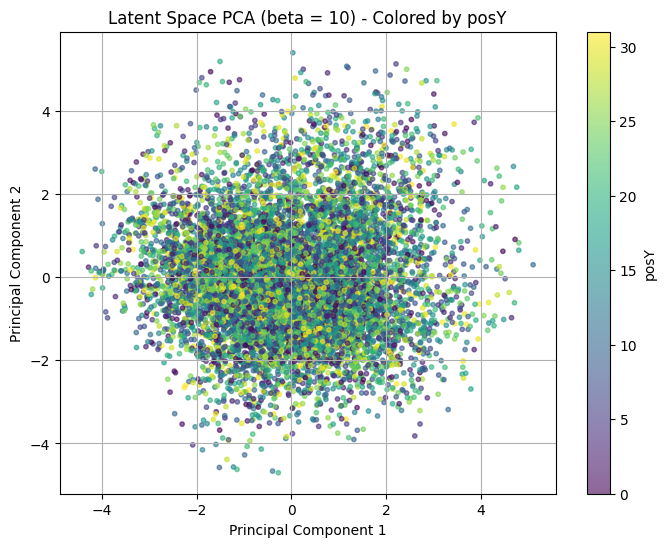

In [ ]:
factors_val_beta10 = latents_classes[:len(latent_means_10), 1:]
factor_names = metadata['latents_names'][1:]

for i, factor_name in enumerate(factor_names):
    if factor_name != 'color':
        plot_pca_colored_by_factor(latent_means_10, factors_val_beta10, i, factor_name)